In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import xgboost as xgb

In [3]:
merged_df = pd.read_csv('/content/drive/MyDrive/CSCI 5502 Data Mining/01 Project/Data/01_Preprocessed_Data/02_Master_Analysis_Data_With_Temp_10_31_12_07.csv')
merged_df.drop(columns='Unnamed: 0', inplace=True)
merged_df.shape

(592085, 42)

In [4]:
# Check for nulls
merged_df.isna().any().any()

False

In [5]:
merged_df.columns

Index(['cu_class_status', 'station_last_updated', 'status_last_reported',
       'station_id', 'station_name', 'station_address', 'station_longitude',
       'station_latitude', 'station_is_returning', 'station_is_renting',
       'station_is_installed', 'station_type', 'docks_available',
       'bikes_available', 'electic_bikes_available', 'smart_bikes_available',
       'classic_bikes_available', 'station_capacity', 'new_docks_available',
       'new_bikes_available', 'datatime_mtd', 'datatime_rnd', 'date_rnd',
       'year_rnd', 'month_rnd', 'day_rnd', 'day_of_week_rnd', 'time_rnd',
       'hour_rnd', 'minute_rnd', 'second_rnd', 'next_avl_bike_time',
       'next_avl_dock_time', 'bike_wait_time', 'dock_wait_time',
       'datetime_temperature', 'temperature_2m', 'precipitation_probability',
       'rain', 'snowfall', 'snow_depth', 'visibility'],
      dtype='object')

# Select the top 10 popular stations

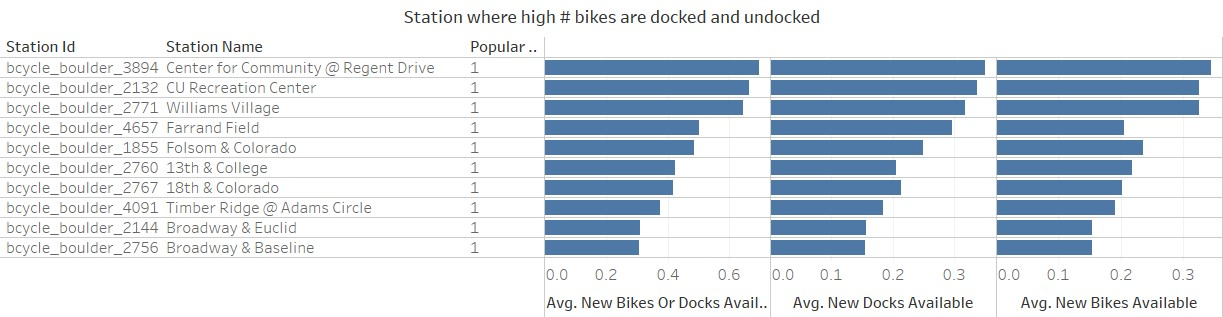

In [16]:
selected_stations = ['bcycle_boulder_3894', 'bcycle_boulder_2132', 'bcycle_boulder_2771','bcycle_boulder_4657','bcycle_boulder_1855','bcycle_boulder_2760','bcycle_boulder_2767','bcycle_boulder_4091','bcycle_boulder_2144','bcycle_boulder_2756']

df= merged_df.copy()
df= df[df['station_id'].isin(selected_stations)]
df['station_id'].unique()

array(['bcycle_boulder_1855', 'bcycle_boulder_2756',
       'bcycle_boulder_2144', 'bcycle_boulder_2132',
       'bcycle_boulder_2760', 'bcycle_boulder_3894',
       'bcycle_boulder_2767', 'bcycle_boulder_2771',
       'bcycle_boulder_4657', 'bcycle_boulder_4091'], dtype=object)

# Select required columns

In [20]:
df['all_bikes_avl_flag'] = (df['station_capacity'] == df['bikes_available']).astype(int)
df['all_docks_avl_flag'] = (df['station_capacity'] == df['docks_available']).astype(int)

# Select month_rnd to split train data and remove it befor modelling
req_cols= ['date_rnd','month_rnd','station_id','cu_class_status','docks_available','bikes_available','all_bikes_avl_flag','all_docks_avl_flag','day_of_week_rnd','hour_rnd','temperature_2m','precipitation_probability','rain','snowfall','snow_depth','visibility','bike_wait_time','dock_wait_time']
  # station_capacity
  # minute_rnd


df= df[req_cols]

df.sample(5)

,date_rnd,month_rnd,station_id,cu_class_status,docks_available,bikes_available,all_bikes_avl_flag,all_docks_avl_flag,day_of_week_rnd,hour_rnd,temperature_2m,precipitation_probability,rain,snowfall,snow_depth,visibility,bike_wait_time,dock_wait_time
242777,2023-11-10,11,bcycle_boulder_2756,Regular,9,4,0,0,Friday,14,-3.2565,0,0.0,0,0.0,28100,12.0,9.0
62315,2023-11-02,11,bcycle_boulder_3894,Regular,16,0,0,1,Thursday,9,4.0435,0,0.0,0,0.0,52600,3.0,12.0
248614,2023-11-10,11,bcycle_boulder_2760,Regular,3,10,0,0,Friday,22,12.4935,0,0.0,0,0.0,89600,21.0,6.0
227792,2023-11-09,11,bcycle_boulder_2132,Regular,18,0,0,1,Thursday,23,8.5435,0,0.0,0,0.0,62500,33.0,51.0
288959,2023-11-18,11,bcycle_boulder_4657,No Class,14,5,0,0,Saturday,7,4.0435,0,0.0,0,0.0,37600,3.0,27.0


In [22]:
# Drop Duplicates
# And remove date column

df=df.drop_duplicates(['date_rnd','station_id','hour_rnd'],keep='first')
df.drop(columns=['date_rnd'],inplace=True)

# Convert catagorical columns to numerical

## One Hot Encode nominal columns

In [23]:
columns_to_encode = ['station_id','cu_class_status','day_of_week_rnd']

df = pd.get_dummies(df,columns = columns_to_encode)
print(df.columns)
df.sample(5)

Index(['month_rnd', 'docks_available', 'bikes_available', 'all_bikes_avl_flag',
       'all_docks_avl_flag', 'hour_rnd', 'temperature_2m',
       'precipitation_probability', 'rain', 'snowfall', 'snow_depth',
       'visibility', 'bike_wait_time', 'dock_wait_time',
       'station_id_bcycle_boulder_1855', 'station_id_bcycle_boulder_2132',
       'station_id_bcycle_boulder_2144', 'station_id_bcycle_boulder_2756',
       'station_id_bcycle_boulder_2760', 'station_id_bcycle_boulder_2767',
       'station_id_bcycle_boulder_2771', 'station_id_bcycle_boulder_3894',
       'station_id_bcycle_boulder_4091', 'station_id_bcycle_boulder_4657',
       'cu_class_status_No Class', 'cu_class_status_Regular',
       'day_of_week_rnd_Friday', 'day_of_week_rnd_Monday',
       'day_of_week_rnd_Saturday', 'day_of_week_rnd_Sunday',
       'day_of_week_rnd_Thursday', 'day_of_week_rnd_Tuesday',
       'day_of_week_rnd_Wednesday'],
      dtype='object')


,month_rnd,docks_available,bikes_available,all_bikes_avl_flag,all_docks_avl_flag,hour_rnd,temperature_2m,precipitation_probability,rain,snowfall,...,station_id_bcycle_boulder_4657,cu_class_status_No Class,cu_class_status_Regular,day_of_week_rnd_Friday,day_of_week_rnd_Monday,day_of_week_rnd_Saturday,day_of_week_rnd_Sunday,day_of_week_rnd_Thursday,day_of_week_rnd_Tuesday,day_of_week_rnd_Wednesday
35,10,20,2,0,0,0,1.8935,0,0.0,0,...,0,0,1,0,0,0,0,0,1,0
261894,11,16,1,0,0,6,7.2435,0,0.0,0,...,0,0,1,1,0,0,0,0,0,0
442199,11,14,0,0,1,21,4.8435,0,0.0,0,...,0,0,1,0,1,0,0,0,0,0
133559,11,1,12,0,0,5,9.7435,0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
533233,12,7,11,0,0,12,6.1435,0,0.0,0,...,0,0,1,0,1,0,0,0,0,0


## Label Encode ordinal columns

In [ ]:
'''
from sklearn.preprocessing import LabelEncoder

data= df.copy()
# Columns to encode
columns_to_encode = ['cu_class_status', 'day_of_week_rnd', 'station_id']

label_encoder = LabelEncoder()

# Apply label encoding to each column
for col in columns_to_encode:
    data[col + '_encoded'] = label_encoder.fit_transform(data[col])

# Drop the original categorical columns if needed
data.drop(columns=columns_to_encode, inplace=True)
data.head()

'''

"\nfrom sklearn.preprocessing import LabelEncoder\n\ndata= df.copy()\n# Columns to encode\ncolumns_to_encode = ['cu_class_status', 'day_of_week_rnd', 'station_id']\n\nlabel_encoder = LabelEncoder()\n\n# Apply label encoding to each column\nfor col in columns_to_encode:\n    data[col + '_encoded'] = label_encoder.fit_transform(data[col])\n\n# Drop the original categorical columns if needed\ndata.drop(columns=columns_to_encode, inplace=True)\ndata.head()\n\n"

# Normalization

In [24]:
cols_to_normalize = ['precipitation_probability','visibility']

df[cols_to_normalize].describe()

,precipitation_probability,visibility
count,5900.000000,5900.000000
mean,3.275593,52640.525424
std,14.371797,20679.349135
min,0.000000,300.000000
25%,0.000000,37400.000000
50%,0.000000,52500.000000
75%,0.000000,68200.000000
max,100.000000,90000.000000


In [25]:
# Create a MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
df[cols_to_normalize].describe()

,precipitation_probability,visibility
count,5900.000000,5900.000000
mean,0.032756,0.583506
std,0.143718,0.230539
min,0.000000,0.000000
25%,0.000000,0.413601
50%,0.000000,0.581940
75%,0.000000,0.756968
max,1.000000,1.000000


# Split train and test data


## Split by ratio

In [ ]:
# Split by ratio


X_bike= df.drop(columns= ['bike_wait_time','dock_wait_time','month_rnd'])
Y_bike = df[['bike_wait_time']]

# Assuming X_bike contains input features and Y_bike contains output variable
X_train, X_test, y_train, y_test = train_test_split(X_bike, Y_bike, test_size=0.2) #, random_state=42)

Mean Squared Error (MSE): 406.01203702104385
Root Mean Squared Error (RMSE): 20.14974037105798
Mean Absolute Error (MAE): 10.310549018826114
R-squared: 0.9624754872294875


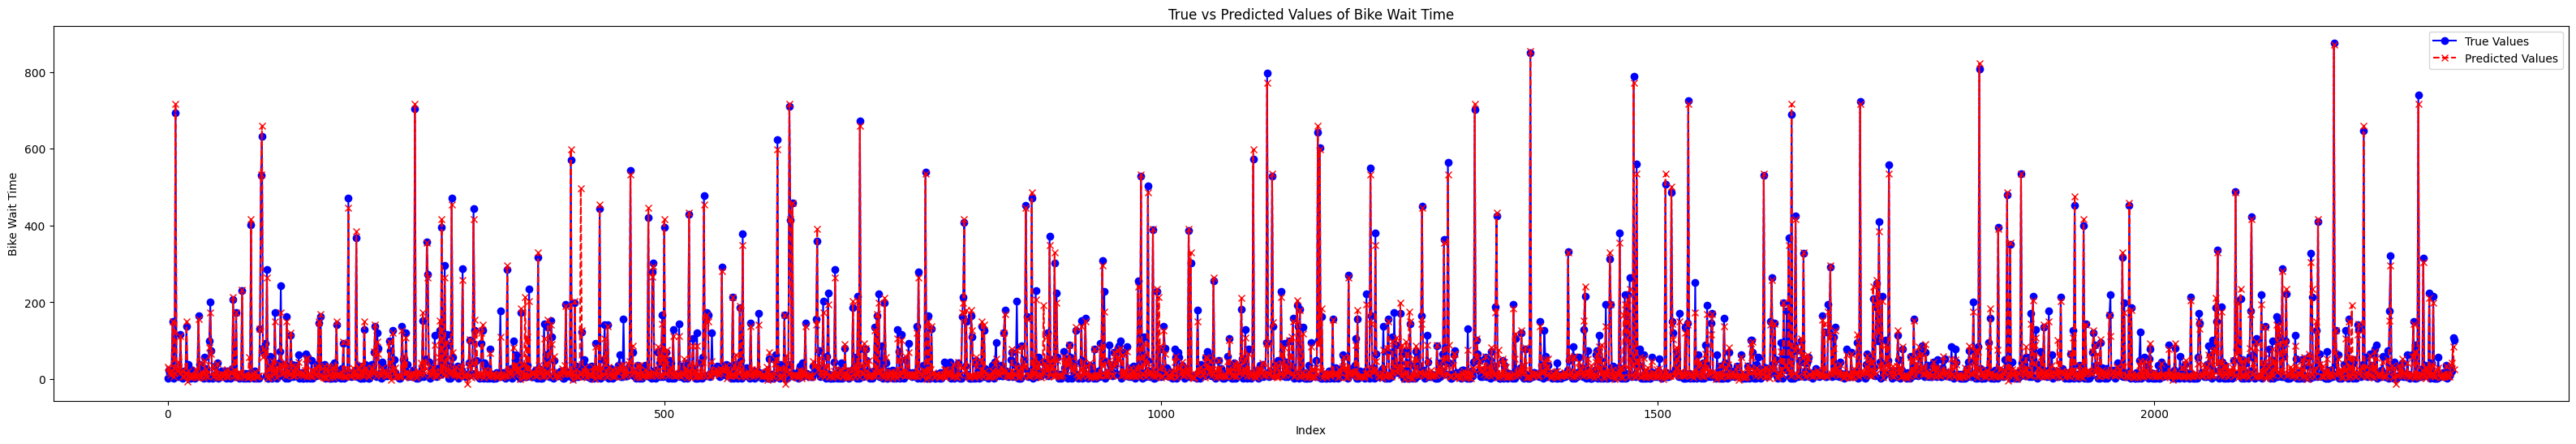

In [ ]:
# best hyper parameters
#xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.2,max_depth=7, n_estimators=150, alpha=10)

xg_reg = xgb.XGBRegressor()
# Fit the model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test)), y_test, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')

plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

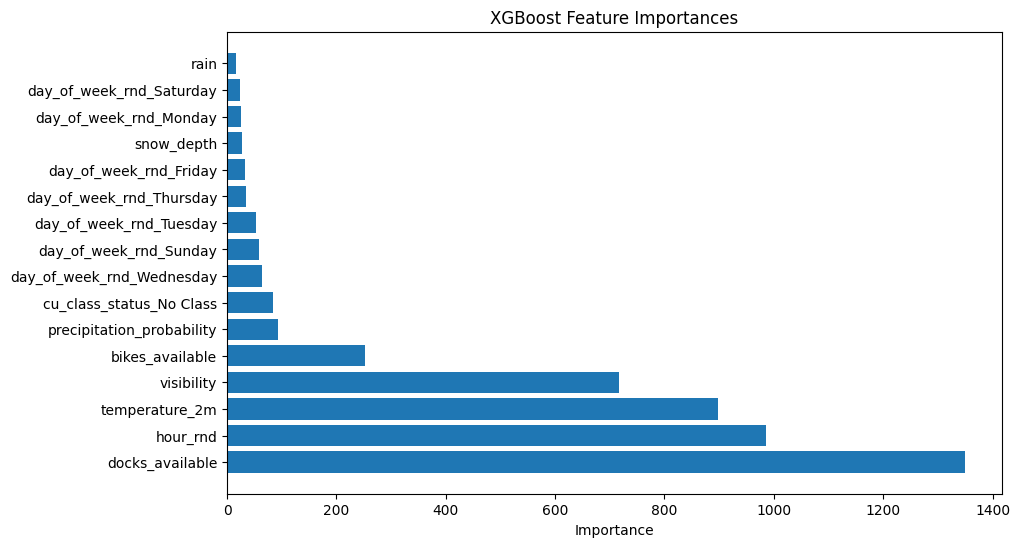

In [ ]:
feature_importances = xg_reg.get_booster().get_score(importance_type='weight')

# Sort the feature importances
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(*zip(*sorted_feature_importances))
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.show()

## Split by ratio: Train and Validate with Nov data | Test with Dec Data

In [26]:
train_data= df[df['month_rnd'] < 12]
test_data= df[df['month_rnd'] == 12]

In [27]:
# Split by ratio

X_bike= train_data.drop(columns= ['bike_wait_time','dock_wait_time','month_rnd'])
Y_bike = train_data[['bike_wait_time']]

# Assuming X_bike contains input features and Y_bike contains output variable
X_train, X_test, y_train, y_test = train_test_split(X_bike, Y_bike, test_size=0.2) #, random_state=42)

Mean Squared Error (MSE): 9024.235919814806
Root Mean Squared Error (RMSE): 94.99597844022033
Mean Absolute Error (MAE): 52.3138151530138
R-squared: 0.607548754374232


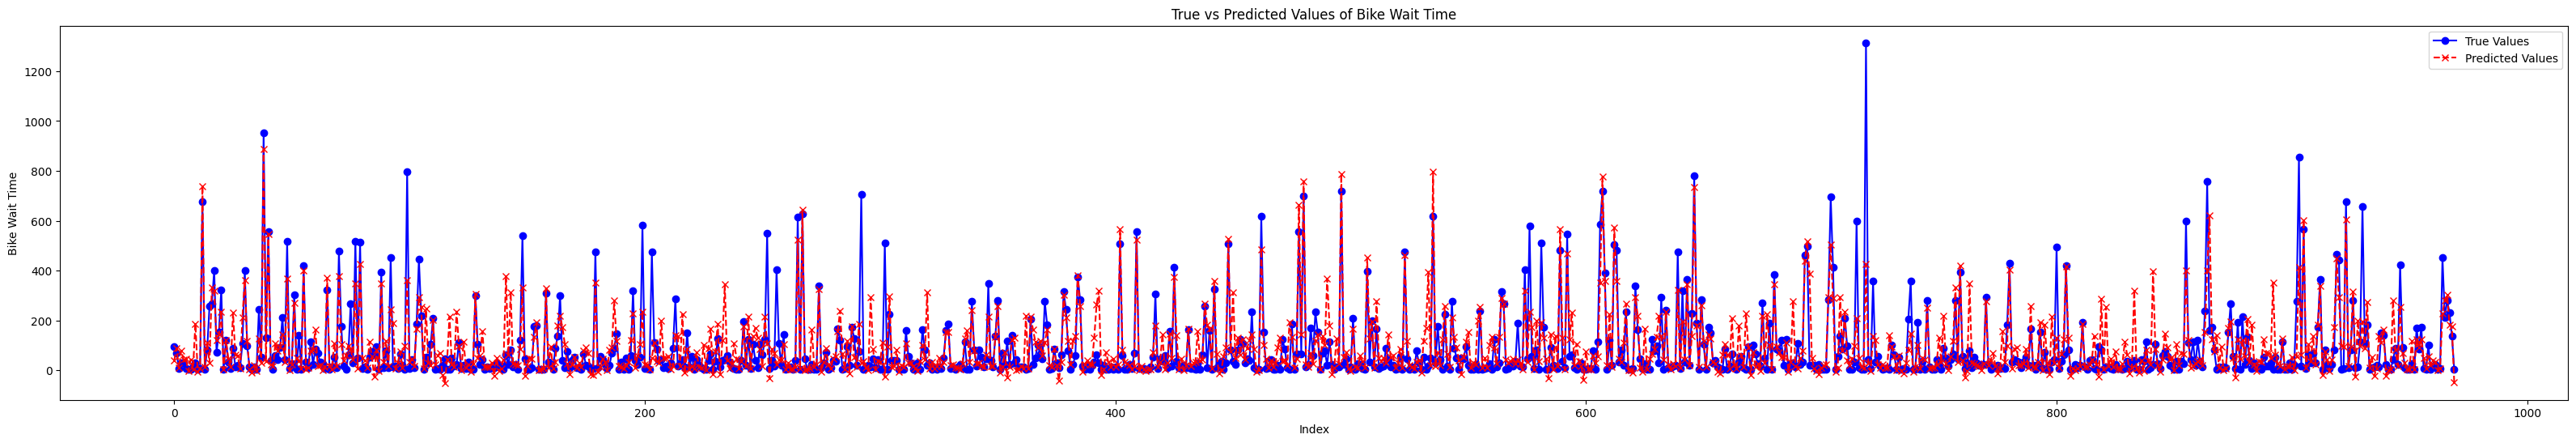

In [28]:
# best hyper parameters
#xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.2,max_depth=7, n_estimators=150, alpha=10)

xg_reg = xgb.XGBRegressor()
# Fit the model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test)), y_test, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')

plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

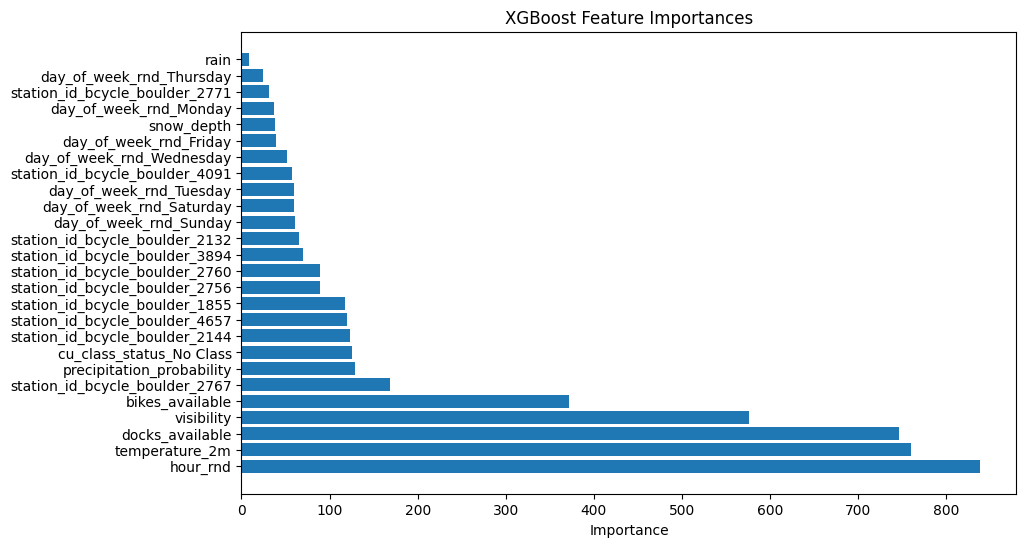

In [29]:
feature_importances = xg_reg.get_booster().get_score(importance_type='weight')

# Sort the feature importances
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(*zip(*sorted_feature_importances))
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.show()

Mean Squared Error (MSE): 23416.52027186613
Root Mean Squared Error (RMSE): 153.02457407836863
Mean Absolute Error (MAE): 81.39016534239764
R-squared: -0.2901618632153251


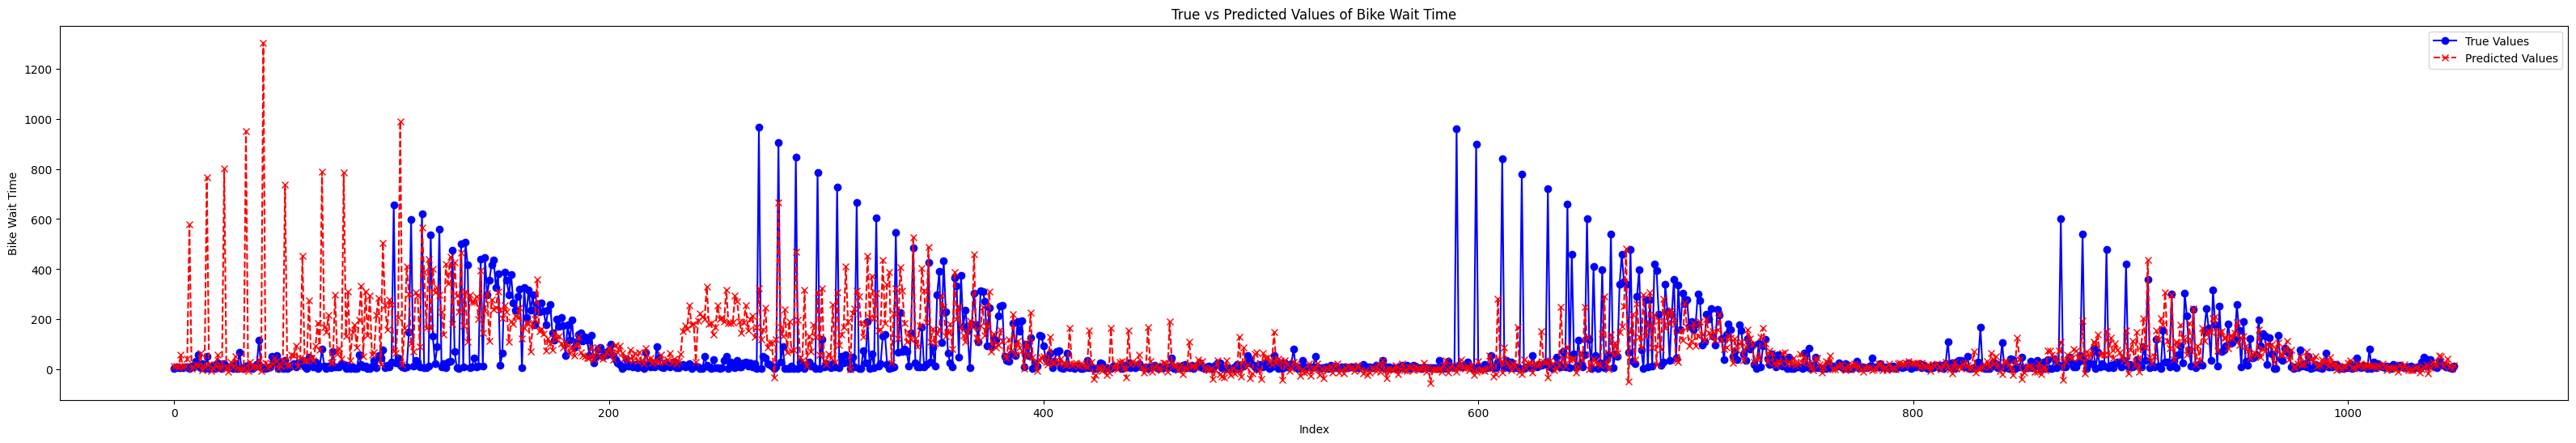

In [30]:
# Test for December data

test_x= test_data.drop(columns= ['bike_wait_time','dock_wait_time','month_rnd'])
test_y= test_data[['bike_wait_time']]

pred_y = xg_reg.predict(test_x)

# Evaluation metrics
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(test_y)), test_y, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(test_y)), pred_y, label='Predicted Values', marker='x', linestyle='--', color='red')

plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

In [ ]:
test_x.columns

Index(['docks_available', 'bikes_available', 'all_bikes_avl_flag',
       'all_docks_avl_flag', 'hour_rnd', 'temperature_2m',
       'precipitation_probability', 'rain', 'snowfall', 'snow_depth',
       'visibility', 'station_id_bcycle_boulder_3894',
       'cu_class_status_No Class', 'cu_class_status_Regular',
       'day_of_week_rnd_Friday', 'day_of_week_rnd_Monday',
       'day_of_week_rnd_Saturday', 'day_of_week_rnd_Sunday',
       'day_of_week_rnd_Thursday', 'day_of_week_rnd_Tuesday',
       'day_of_week_rnd_Wednesday'],
      dtype='object')

# Convert output to categorical from the regression prediction

1. very low- within 15mins
2. low- within 30mins
3. medium- within 60 mins
4. high- more than 60mins

In [36]:
def convert_target_catg (wait_time):
  if(wait_time <= 15):
    return 1
  elif(wait_time <= 30):
    return 2
  elif(wait_time <= 60):
    return 3
  else:
    return 4

ddf= pd.DataFrame()
ddf['actual_wait_time']= test_y['bike_wait_time'].values
ddf['predicted_wait_time']= pred_y
ddf['actual_wait_time_ctg']= ddf['actual_wait_time'].apply(convert_target_catg)
ddf['predicted_wait_time_ctg']= ddf['predicted_wait_time'].apply(convert_target_catg)

ddf.sample(10)

,actual_wait_time,predicted_wait_time,actual_wait_time_ctg,predicted_wait_time_ctg
330,6.0,28.049715,1,2
815,24.0,28.553684,2,2
730,12.0,130.564209,1,4
480,27.0,35.083916,2,3
270,3.0,119.180885,1,4
488,12.0,-13.898272,1,1
718,72.0,122.507744,4,4
521,12.0,-9.066613,1,1
538,6.0,-14.545220,1,1
1032,12.0,10.764484,1,1


In [38]:
# Evaluation

from sklearn.metrics import classification_report
print(classification_report(ddf['actual_wait_time_ctg'].values, ddf['predicted_wait_time_ctg'].values))

from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming test_y and predict_y are your true and predicted labels
conf_matrix = confusion_matrix(ddf['actual_wait_time_ctg'].values, ddf['predicted_wait_time_ctg'].values)
accuracy = accuracy_score(ddf['actual_wait_time_ctg'].values, ddf['predicted_wait_time_ctg'].values)

print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy:", accuracy)

              precision    recall  f1-score   support

           1       0.70      0.39      0.50       503
           2       0.15      0.13      0.14       178
           3       0.17      0.24      0.20       110
           4       0.47      0.83      0.60       259

    accuracy                           0.44      1050
   macro avg       0.37      0.40      0.36      1050
weighted avg       0.49      0.44      0.43      1050

Confusion Matrix:
[[194 106  66 137]
 [ 50  24  39  65]
 [ 21  19  26  44]
 [ 12   8  24 215]]

Accuracy: 0.43714285714285717


#Modelling and Evaluation

## 1. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()
model.fit(x_train,y_train_bike)
y_pred=model.predict(x_test)

Mean Squared Error (MSE): 16045.049243950301
Root Mean Squared Error (RMSE): 126.66905401063948
Mean Absolute Error (MAE): 74.43894336661587
R-squared: 0.12467508790644366


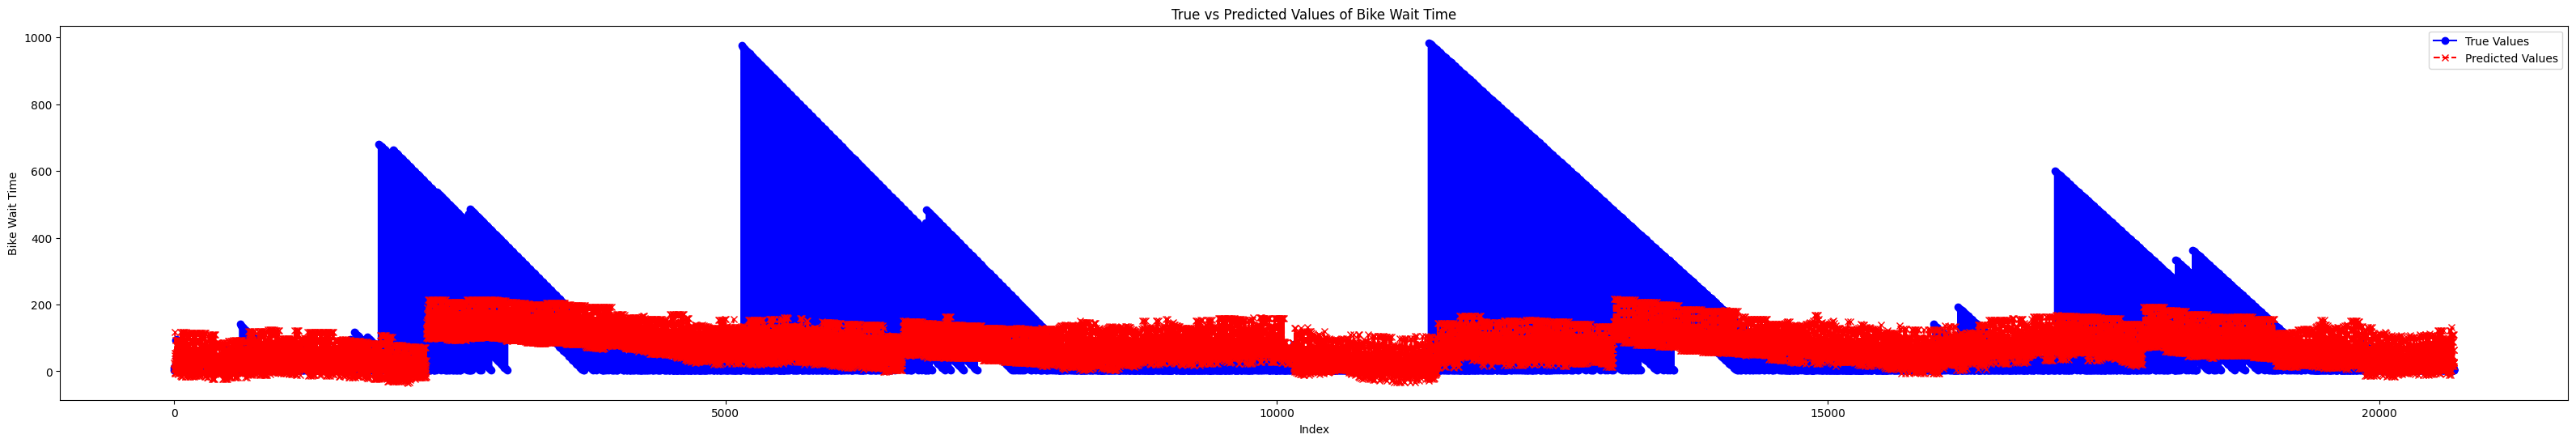

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# Evaluation metrics
mse = mean_squared_error(y_test_bike, y_pred)
r2 = r2_score(y_test_bike, y_pred)
mae = mean_absolute_error(y_test_bike, y_pred)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test_bike)), y_test_bike, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test_bike)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

## 2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model= RandomForestRegressor()
model.fit(x_train,y_train_bike)
y_pred=model.predict(x_test)

<ipython-input-134-4ba78877838c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train_bike)


Mean Squared Error (MSE): 25395.861432716018
Root Mean Squared Error (RMSE): 159.3607901358299
Mean Absolute Error (MAE): 72.17013297229342
R-squared: -0.3854510408881324


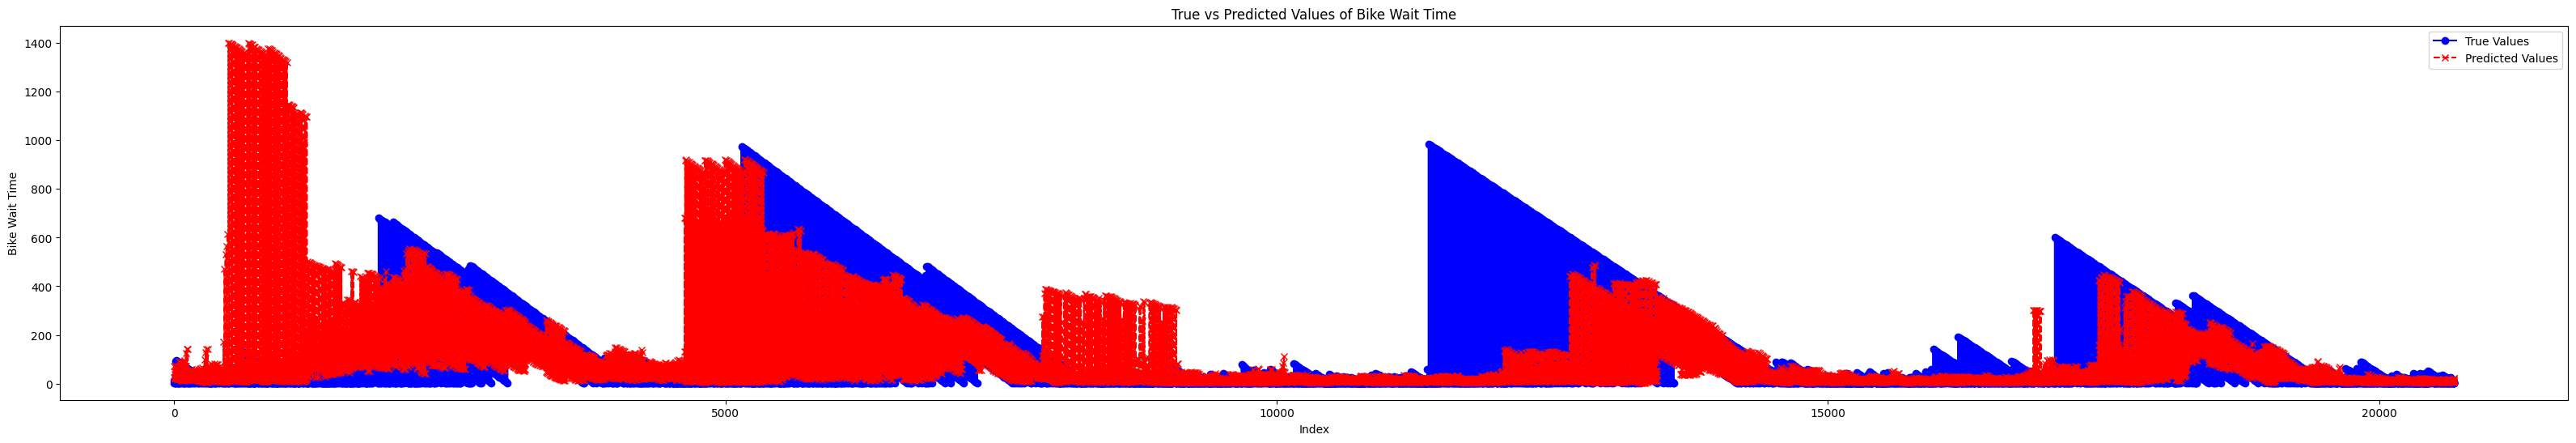

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# Evaluation metrics
mse = mean_squared_error(y_test_bike, y_pred)
r2 = r2_score(y_test_bike, y_pred)
mae = mean_absolute_error(y_test_bike, y_pred)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test_bike)), y_test_bike, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test_bike)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

## 3. XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor

model= XGBRegressor()
model.fit(x_train,y_train_bike)
y_pred=model.predict(x_test)

Mean Squared Error (MSE): 6237.9386427402105
Root Mean Squared Error (RMSE): 78.98062194450111
Mean Absolute Error (MAE): 38.312687733481006
R-squared: -1.7780771241714253


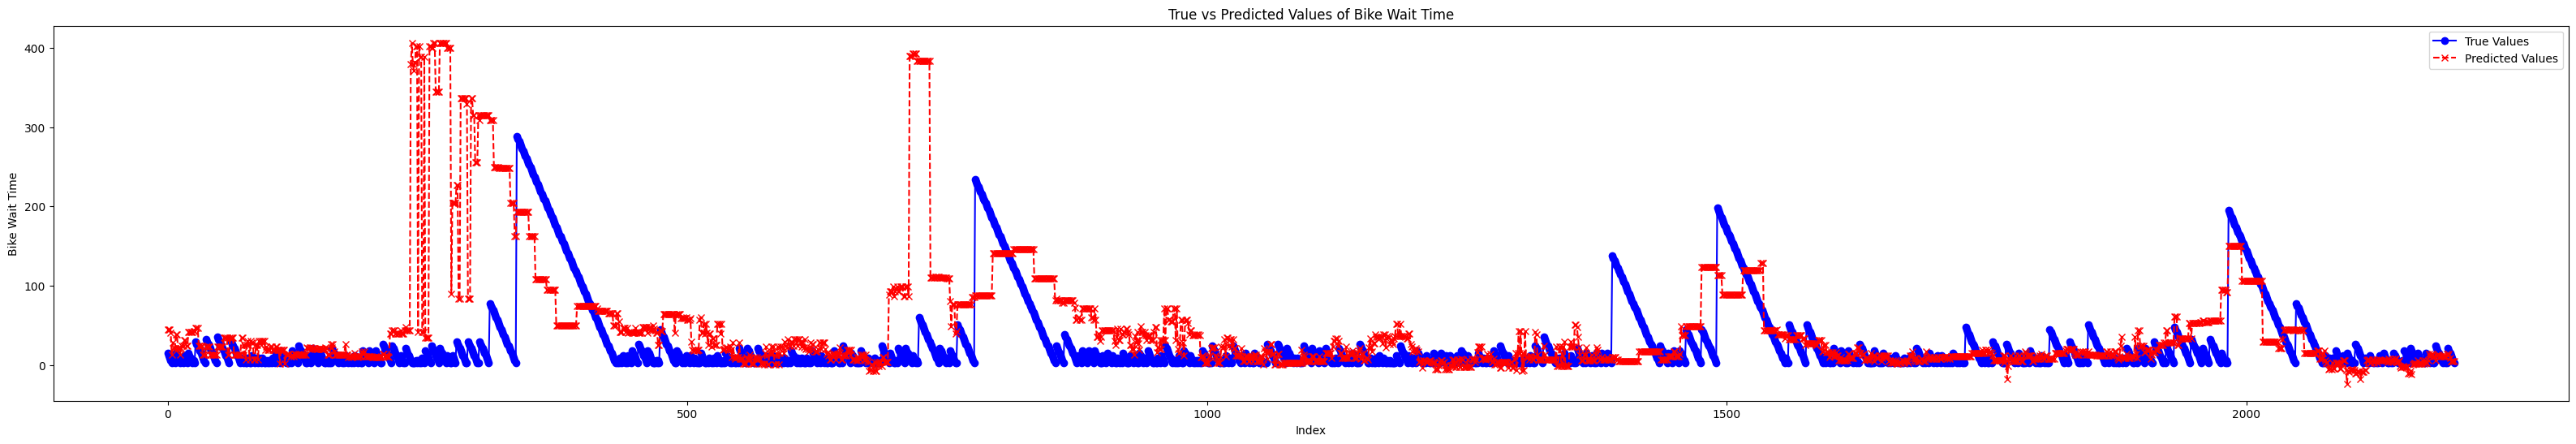

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# Evaluation metrics
mse = mean_squared_error(y_test_bike, y_pred)
r2 = r2_score(y_test_bike, y_pred)
mae = mean_absolute_error(y_test_bike, y_pred)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test_bike)), y_test_bike, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test_bike)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

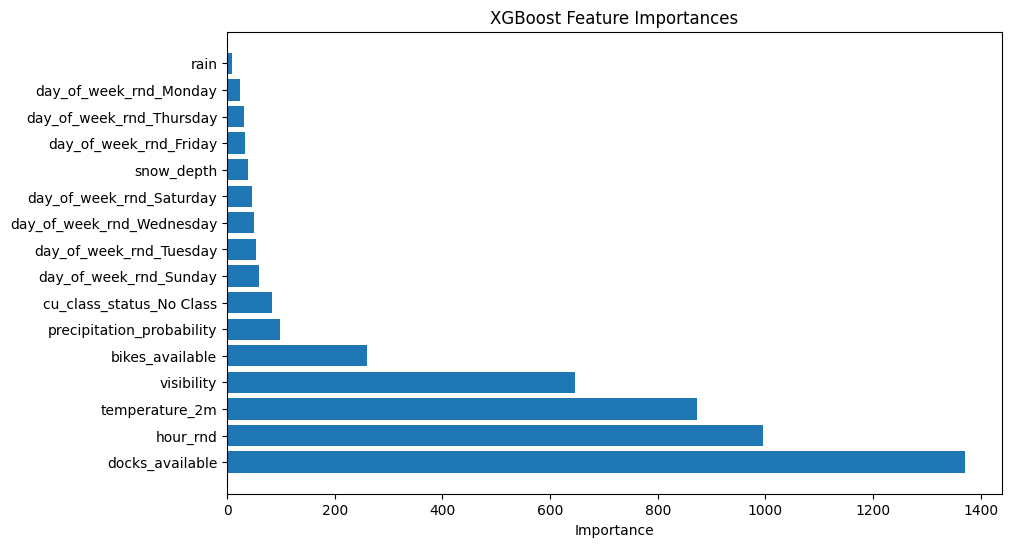

In [ ]:
# Assuming xgb_model is your trained XGBoost model
# You can access feature importances directly from the model
feature_importances = model.get_booster().get_score(importance_type='weight')

# Sort the feature importances
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(*zip(*sorted_feature_importances))
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.show()

Mean Squared Error (MSE): 18514.823139761753
Root Mean Squared Error (RMSE): 136.0691851219877
Mean Absolute Error (MAE): 73.17005695965496
R-squared: -0.010061464495053851


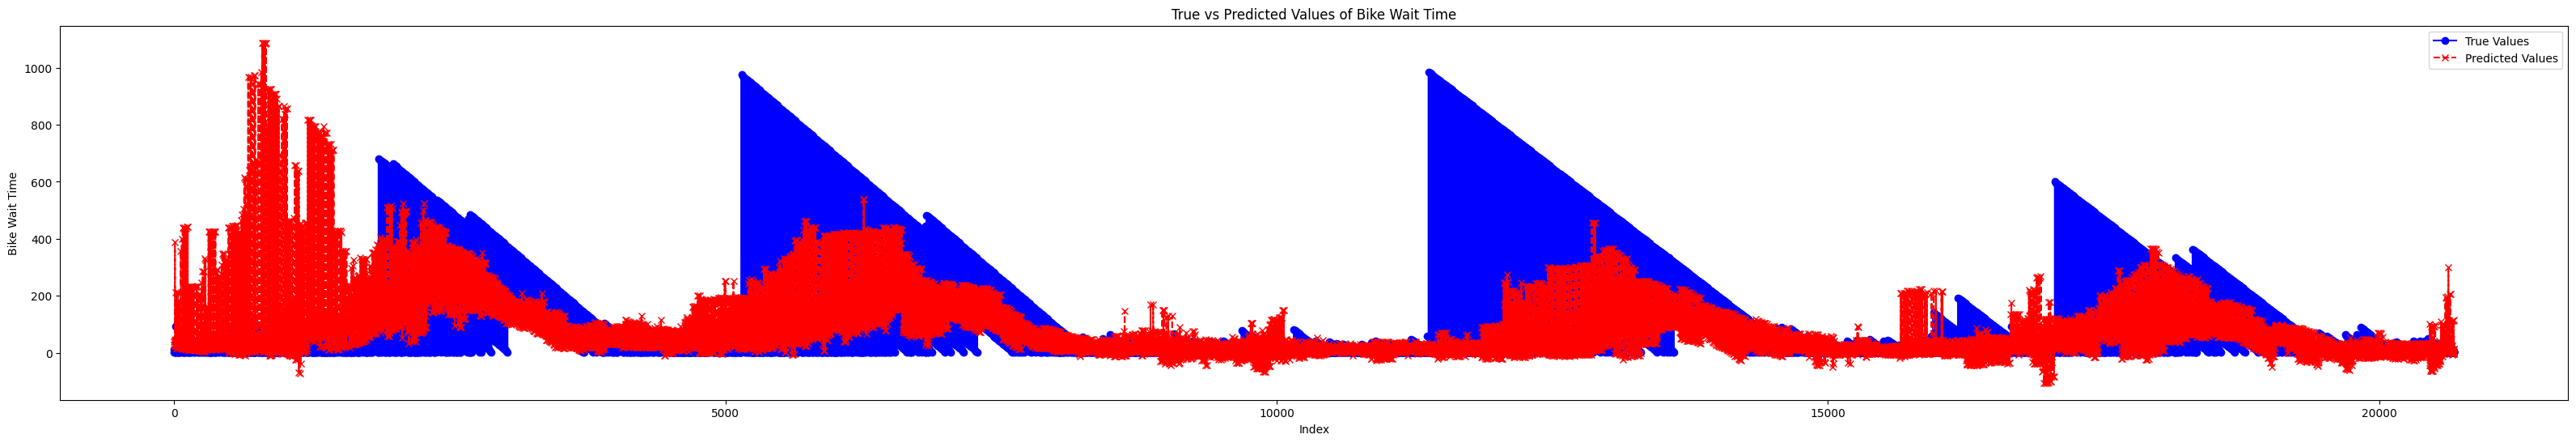

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.2,
                          max_depth=7, n_estimators=150, alpha=10)
model.fit(x_train,y_train_bike)
y_pred=model.predict(x_test)

# Evaluation metrics
mse = mean_squared_error(y_test_bike, y_pred)
r2 = r2_score(y_test_bike, y_pred)
mae = mean_absolute_error(y_test_bike, y_pred)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test_bike)), y_test_bike, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test_bike)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

## 4. Exponential

In [ ]:
import statsmodels.api as sm

# Assuming 'X' is your feature matrix
X = sm.add_constant(x_train)  # Add a constant term for the intercept
y = y_train_bike  # Original target variable

# Fit a GLM with a log link and gamma distribution
model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log()))
result = model.fit()
print(result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:         bike_wait_time   No. Observations:                94044
Model:                            GLM   Df Residuals:                    94016
Model Family:                   Gamma   Df Model:                           27
Link Function:                    log   Scale:                          2.6027
Method:                          IRLS   Log-Likelihood:            -4.9999e+05
Date:                Sat, 09 Dec 2023   Deviance:                   1.5764e+05
Time:                        23:35:07   Pearson chi2:                 2.45e+05
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1995
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

# Evaluation by categories

In [ ]:
# Filters
filter_regular_class= (x_test['day_of_week_rnd_Monday']==1) | (x_test['day_of_week_rnd_Tuesday']==1) | (x_test['day_of_week_rnd_Wednesday']==1) | (x_test['day_of_week_rnd_Thursday']==1) | (x_test['day_of_week_rnd_Friday']==1)
filter_mrng_to_eve= (x_test['hour_rnd'] >= 9) & (x_test['hour_rnd'] <= 20)
filter_no_bike_avl= (x_test['all_docks_avl_flag'] == 1)

<ipython-input-208-e688828b207d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_predictions['predictions']= y_pred


Mean Squared Error (MSE): 11546.726961329003
Root Mean Squared Error (RMSE): 107.45569766805761
Mean Absolute Error (MAE): 56.03757933344711
R-squared: -0.12470737818648314


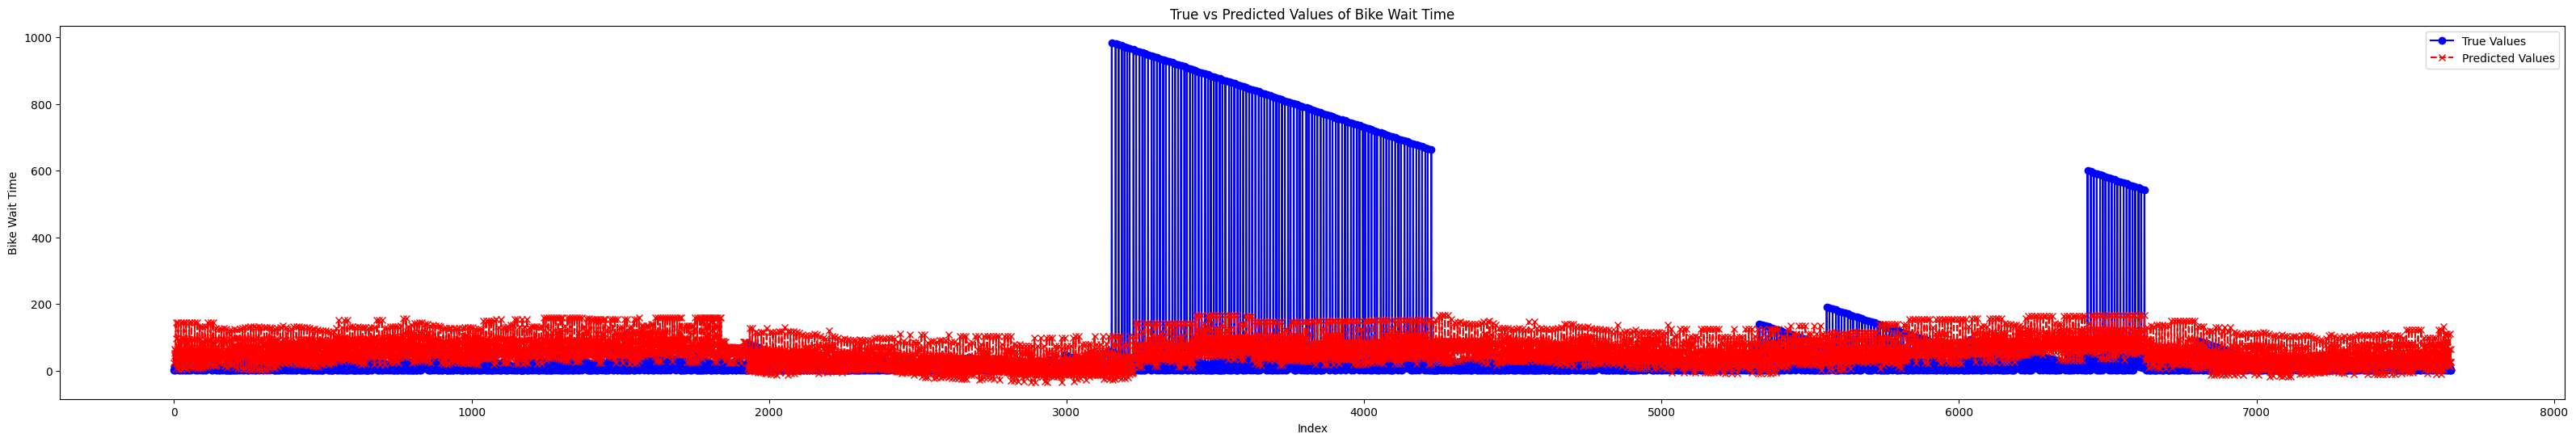

In [ ]:
# Convert test results into a dataframe for fitering
actual_predictions= y_test_bike
actual_predictions['predictions']= y_pred
actual_predictions

# Filter based on indexes- change as required
index= x_test[filter_regular_class & filter_mrng_to_eve].index
actual= actual_predictions['bike_wait_time'].loc[index]
predicted= actual_predictions['predictions'].loc[index]


# Evaluation metrics
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)
mae = mean_absolute_error(actual, predicted)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(actual)), actual, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(actual)), predicted, label='Predicted Values', marker='x', linestyle='--', color='red')

plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

In [ ]:
x_test.columns

Index(['docks_available', 'bikes_available', 'all_bikes_avl_flag',
       'all_docks_avl_flag', 'hour_rnd', 'minute_rnd', 'temperature_2m',
       'precipitation_probability', 'rain', 'snowfall', 'snow_depth',
       'visibility', 'station_id_bcycle_boulder_1855',
       'station_id_bcycle_boulder_2132', 'station_id_bcycle_boulder_2144',
       'station_id_bcycle_boulder_2756', 'station_id_bcycle_boulder_2760',
       'station_id_bcycle_boulder_2767', 'station_id_bcycle_boulder_2771',
       'station_id_bcycle_boulder_3894', 'station_id_bcycle_boulder_4091',
       'station_id_bcycle_boulder_4657', 'cu_class_status_No Class',
       'cu_class_status_Regular', 'day_of_week_rnd_Friday',
       'day_of_week_rnd_Monday', 'day_of_week_rnd_Saturday',
       'day_of_week_rnd_Sunday', 'day_of_week_rnd_Thursday',
       'day_of_week_rnd_Tuesday', 'day_of_week_rnd_Wednesday'],
      dtype='object')

<ipython-input-267-273f8d218945>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_predictions['predictions']= y_pred


Mean Squared Error (MSE): 492.8972878127659
Root Mean Squared Error (RMSE): 22.201290228560275
Mean Absolute Error (MAE): 16.306356415825505
R-squared: -15.050770681714209


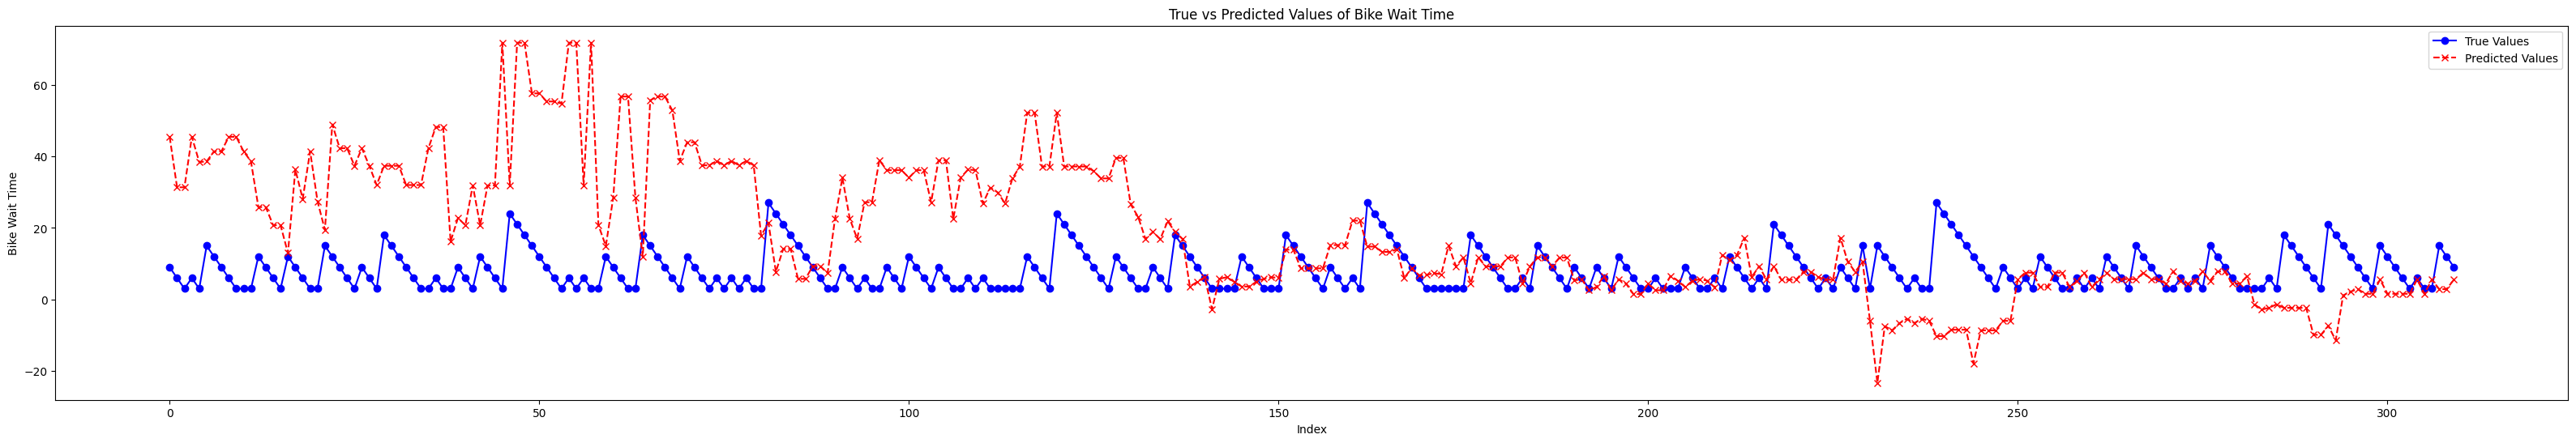

In [ ]:
# Test only for C4C, Regular class days, Dec 1- 7, 9AM - 1PM

filter_regular_class= (x_test['day_of_week_rnd_Monday']==1) | (x_test['day_of_week_rnd_Tuesday']==1) | (x_test['day_of_week_rnd_Wednesday']==1) | (x_test['day_of_week_rnd_Thursday']==1) | (x_test['day_of_week_rnd_Friday']==1)
filter2= (x_test['station_id_bcycle_boulder_3894']==1) & (x_test['hour_rnd'].isin([9,10,11,12]))

# Convert test results into a dataframe for fitering
actual_predictions= y_test_bike
actual_predictions['predictions']= y_pred
actual_predictions

# Filter based on indexes- change as required
index= x_test[filter_regular_class & filter2].index
actual= actual_predictions['bike_wait_time'].loc[index]
predicted= actual_predictions['predictions'].loc[index]

# Evaluation metrics
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)
mae = mean_absolute_error(actual, predicted)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(actual)), actual, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(actual)), predicted, label='Predicted Values', marker='x', linestyle='--', color='red')

plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

### Model - XGBRegressor

In [ ]:
X_bike = df[['hour_rnd', 'docks_available', 'bikes_available', 'station_capacity',
 'temperature_2m', 'precipitation_probability',
       'snow_depth', 'visibility', 'cu_class_status_encoded',
       'day_of_week_rnd_encoded', 'station_name_encoded']]
Y_bike = df[['bike_wait_time']]
X_dock = df[['hour_rnd', 'docks_available', 'bikes_available', 'station_capacity',
     'temperature_2m', 'precipitation_probability',
       'snow_depth', 'visibility', 'cu_class_status_encoded',
       'day_of_week_rnd_encoded', 'station_name_encoded']]
Y_dock = df[['dock_wait_time']]

Mean Squared Error (MSE): 103.57132978427703
Root Mean Squared Error (RMSE): 10.177000038531837
Mean Absolute Error (MAE): 8.003966333988672
R-squared: 0.9957908552211195


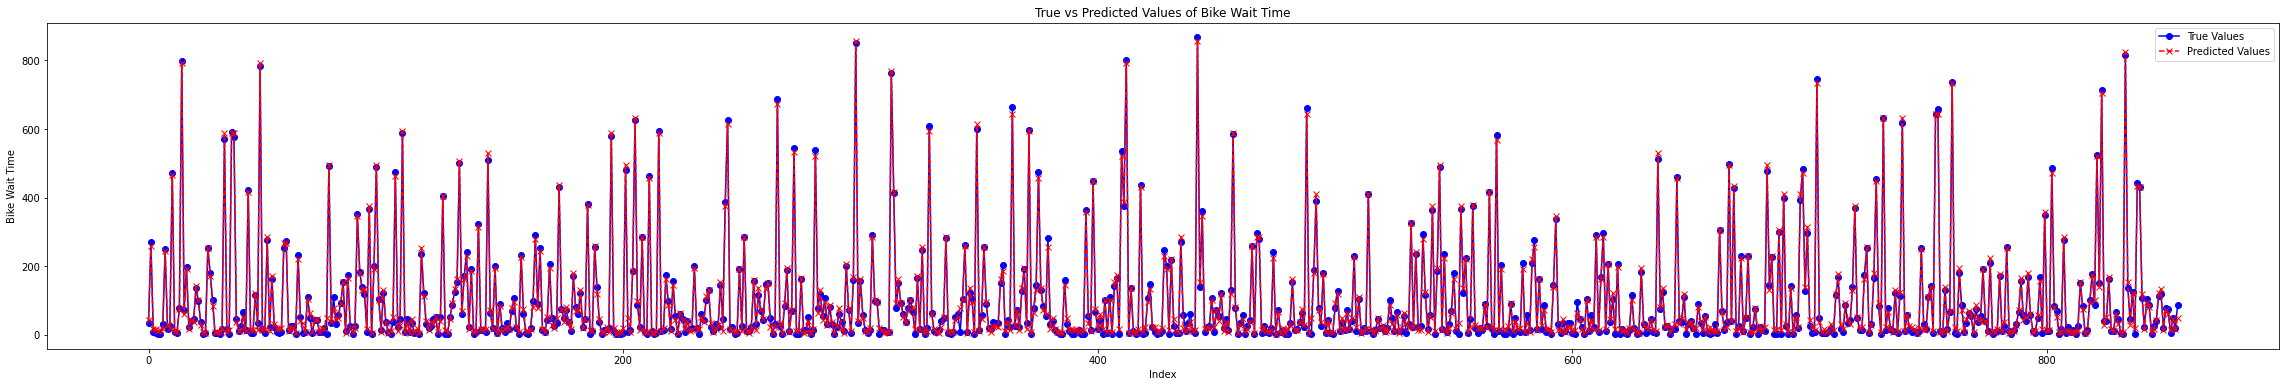

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import xgboost as xgb

# Assuming X_bike contains input features and Y_bike contains output variable
X_train, X_test, y_train, y_test = train_test_split(X_bike, Y_bike, test_size=0.2, random_state=42)

# # # Initialize XGBoost regressor
# xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
#                           max_depth=5, alpha=10, n_estimators=10)

# best hyper parameters
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.2,
                          max_depth=7, n_estimators=150, alpha=10)
# Fit the model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)



### Prediction vs True data

In [ ]:
import pandas as pd

# Convert y_test and y_pred DataFrame columns to lists
y_test_list = y_test['bike_wait_time'].tolist()  # Replace 'your_column_name' with the actual column name
y_pred_list = y_pred.tolist()

# Creating a DataFrame to display y_pred and y_test
results_df = pd.DataFrame({'True_Values': y_test_list, 'Predicted_Values': y_pred_list})

# Displaying the DataFrame
print(results_df)

     True_Values  Predicted_Values
0           33.0         44.567402
1          270.0        259.870911
2            9.0         15.564244
3            6.0         17.138262
4            3.0         10.229012
..           ...               ...
851         75.0         59.451157
852          6.0         13.890688
853         48.0         47.051151
854         21.0         16.554155
855         87.0         49.044563

[856 rows x 2 columns]


### Feature Importance

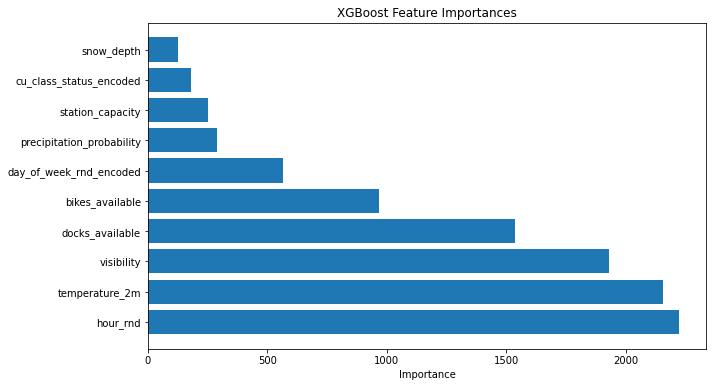

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_model is your trained XGBoost model
# You can access feature importances directly from the model
feature_importances = xg_reg.get_booster().get_score(importance_type='weight')

# Sort the feature importances
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(*zip(*sorted_feature_importances))
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.show()



### Hyper Parameter Tuning

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Mean Squared Error (MSE): 495.51041474431787
Root Mean Squared Error (RMSE): 22.260063224176115
Mean Absolute Error (MAE): 10.355752582105296
R-squared: 0.9780532305476894


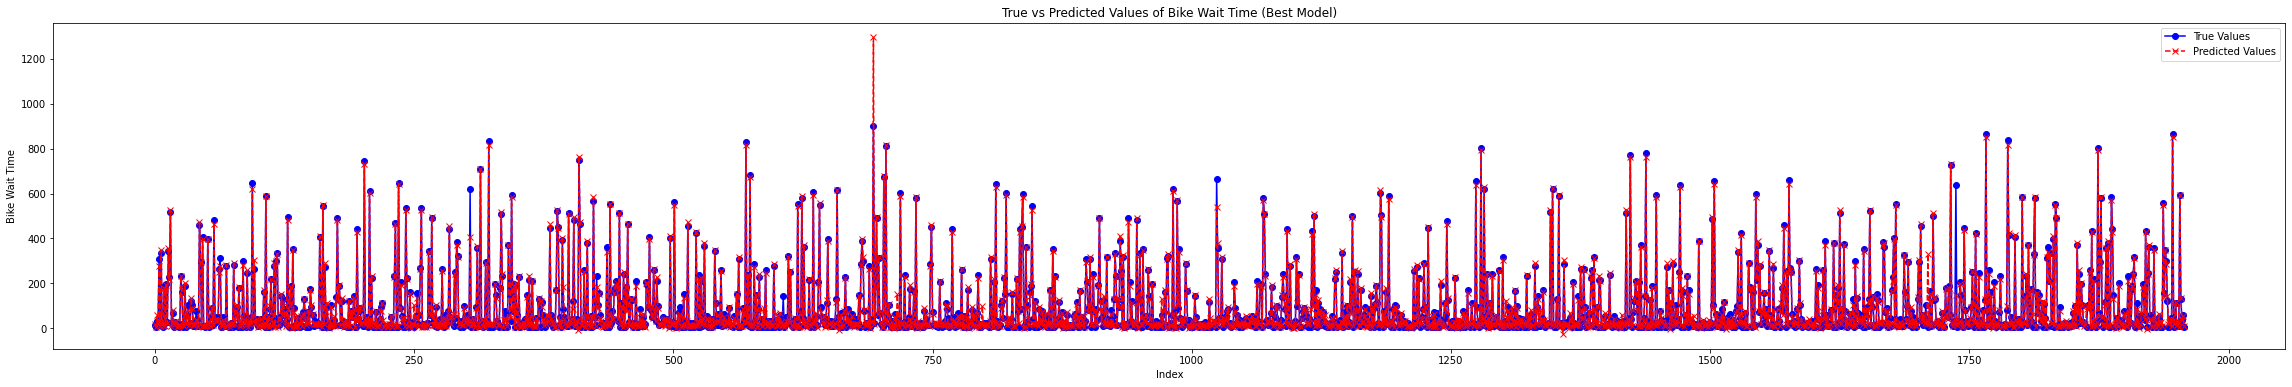

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their values to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'colsample_bytree': [0.3, 0.5, 0.7]  # Fraction of features used per tree
}

# Initialize XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', alpha=10, random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_xg_reg = grid_search.best_estimator_

# Predict using the best model
y_pred = best_xg_reg.predict(X_test)

# Evaluation metrics with the best model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart with the best model
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test)), y_test, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')

plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time (Best Model)')
plt.legend()
plt.show()
